In [21]:
import numpy as np
from tqdm.notebook import tqdm
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.datasets as datasets
from torch.utils.data import DataLoader, random_split
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import os
import glob
import PIL.Image as Image


In [41]:
from google.colab import drive
drive.mount('/content/drive')
#data_dir = '/content/drive/My Drive/Colab Notebooks/DLCV project 1/hotdog_nothotdog'
data_dir = '/content/drive/MyDrive/DSV/hotdog_nothotdog'



Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [42]:
!cp -r /content/drive/MyDrive/DSV/hotdog_nothotdog /content/hotdog_nothotdog


In [43]:
data_dir = '/content/hotdog_nothotdog'

In [22]:
import numpy as np
import matplotlib.pyplot as plt
import os
import glob
from PIL import Image
import torch


class Hotdog_NotHotdog(torch.utils.data.Dataset):
    def __init__(self, train, transform, data_path):
        'Initialization'
        self.transform = transform
        data_path = os.path.join(data_path, 'train' if train else 'test')
        image_classes = [os.path.split(d)[1] for d in glob.glob(data_path + '/*') if os.path.isdir(d)]
        image_classes.sort()
        self.name_to_label = {c: id for id, c in enumerate(image_classes)}
        self.image_paths = glob.glob(data_path + '/*/*.jpg')

    def __len__(self):
        'Returns the total number of samples'
        return len(self.image_paths)

    def __getitem__(self, idx):
        'Generates one sample of data'
        image_path = self.image_paths[idx]
        image = Image.open(image_path).convert('RGB')
        c = os.path.split(os.path.split(image_path)[0])[1]
        y = self.name_to_label[c]
        X = self.transform(image)
        return X, y


def get_mean_std(loader):
    mean = 0.
    std = 0.
    total_images_count = 0

    for images, _ in loader:

        if len(images.shape) == 3:
            images = images.unsqueeze(0)

        batch_samples = images.size(0)
        total_images_count += batch_samples


        mean += images.mean([0, 2, 3]) * batch_samples

    mean /= total_images_count

    for images, _ in loader:
        if len(images.shape) == 3:
            images = images.unsqueeze(0)

        batch_samples = images.size(0)
        std += ((images - mean.unsqueeze(1).unsqueeze(2)) ** 2).mean([0, 2, 3]) * batch_samples

    std = torch.sqrt(std / total_images_count)

    return mean, std


def set_plot_style():
    plt.rcParams['axes.prop_cycle'] = plt.cycler(color=['#990000', '#2F3EEA', '#030F4F'])
    plt.rcParams['figure.facecolor'] = 'white'
    plt.rcParams['axes.grid'] = True
    plt.rcParams['grid.color'] = '#d3d3d3'


def visualize_samples(train_loader):
    images, labels = next(iter(train_loader))
    plt.figure(figsize=(20, 10))
    color_primary = '#990000'  # University red
    color_secondary = '#2F3EEA'  # University blue

    for i in range(min(4, len(images))):
        plt.subplot(1, 4, i+1)
        plt.imshow(np.transpose(images[i].numpy(), (1, 2, 0)))
        plt.title(['Hotdog', 'Not Hotdog'][labels[i].item()], color=color_primary)
        plt.axis('off')

    plt.suptitle('Sample Training Images', fontsize=24, color=color_secondary)
    plt.tight_layout()
    plt.show()



def plot_training_curves(nn_out, filename='train_baseline.png'):
    epochs = len(nn_out['train_acc'])
    epoch_range = range(1, epochs + 1)

    # Set up university colors
    color_primary = '#990000'  # University red
    color_secondary = '#2F3EEA'  # University blue
    color_accent = '#030F4F'  # Dark blue

    plt.figure(figsize=(18, 10))

    # Plot Loss
    plt.subplot(2, 1, 1)
    plt.plot(epoch_range, nn_out['train_loss'], label='NN Train Loss', color=color_primary, linestyle='-')
    if 'val_loss' in nn_out:
        plt.plot(epoch_range, nn_out['val_loss'], label='NN Val Loss', color=color_primary, linestyle='--')
        plt.title('Training and Validation Loss', fontsize=16, color=color_accent)
    else:
        plt.plot(epoch_range, nn_out['test_loss'], label='NN Test Loss', color=color_primary, linestyle='--')
        plt.title('Training and Test Loss', fontsize=16, color=color_accent)
    plt.xlabel('Epoch', fontsize=14)
    plt.ylabel('Loss', fontsize=14)
    plt.legend(fontsize=12)
    plt.grid(True, linestyle='--', alpha=0.7)

    # Plot Accuracy
    plt.subplot(2, 1, 2)
    plt.plot(epoch_range, [acc * 100 for acc in nn_out['train_acc']],
             label='NN Train Acc', color=color_secondary, linestyle='-')
    if 'val_acc' in nn_out:
        plt.plot(epoch_range, [acc * 100 for acc in nn_out['val_acc']],
                 label='NN Val Acc', color=color_secondary, linestyle='--')
        plt.title('Training and Validation Accuracy', fontsize=16, color=color_accent)
    else:
        plt.plot(epoch_range, [acc * 100 for acc in nn_out['test_acc']],
                 label='NN Test Acc', color=color_secondary, linestyle='--')
        plt.title('Training and Test Accuracy', fontsize=16, color=color_accent)

    plt.xlabel('Epoch', fontsize=14)
    plt.ylabel('Accuracy (%)', fontsize=14)
    plt.ylim(0, 100)
    plt.legend(fontsize=12)
    plt.grid(True, linestyle='--', alpha=0.7)

    plt.tight_layout()


    plt.savefig(filename)
    plt.show()



In [81]:
import torch.nn as nn


class ChunkyBoy(nn.Module):
    def __init__(self):
        super(ChunkyBoy, self).__init__()
        self.convolutional = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=8, kernel_size=3, padding=1),
            nn.BatchNorm2d(8),
            nn.ReLU(),

            nn.Conv2d(in_channels=8, out_channels=32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2),

            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),

            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )

        self.fully_connected = nn.Sequential(
            nn.Dropout(0.7),
            nn.Linear(56 * 56 * 64, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.Dropout(0.7),
            nn.Linear(256, 1)
        )

    def forward(self, x):
        x = self.convolutional(x)
        #print(x.shape)
        x = x.view(x.size(0), -1)
        x = self.fully_connected(x)
        return x


class ChunkyBoyCut(nn.Module):
    def __init__(self):
        super(ChunkyBoyCut, self).__init__()
        self.convolutional1 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=8, kernel_size=3, padding=1),
            nn.BatchNorm2d(8)
        )
        self.convolutional2 = nn.Sequential(
            nn.ReLU(),
            nn.Conv2d(in_channels=8, out_channels=32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32)
        )
        self.convolutional3 = nn.Sequential(
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64)
        )
        self.convolutional4 = nn.Sequential(
            nn.ReLU(),
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64)
        )
        self.convolutionalrest = nn.Sequential(
            nn.ReLU(),
            nn.MaxPool2d(2),
        )

        self.fully_connected = nn.Sequential(
            nn.Dropout(0.7),
            nn.Linear(56 * 56 * 64, 256),
            nn.ReLU(),
            nn.Dropout(0.7),
            nn.Linear(256, 1)
        )

    def forward(self, x, cut=0):
        x = self.convolutional1(x)
        print(f"After conv1: {x.shape}")  # Track shape
        if cut == 1:
            return x
        x = self.convolutional2(x)
        print(f"After conv2: {x.shape}")  # Track shape
        if cut == 2:
            return x
        x = self.convolutional3(x)
        print(f"After conv3: {x.shape}")  # Track shape
        if cut == 3:
            return x
        x = self.convolutional4(x)
        print(f"After conv4: {x.shape}")  # Track shape
        if cut == 4:
            return x
        x = self.convolutionalrest(x)
        print(f"After convrest: {x.shape}")  # Track shape
        x = x.view(x.size(0), -1)  # Flatten the tensor
        x = self.fully_connected(x)
        return x



In [82]:
def train(model, optimizer, device, train_loader, val_loader, num_epochs=10, patience=10):
#def train(model, optimizer, device, train_loader, test_loader, num_epochs=1):
    loss_fun = nn.BCEWithLogitsLoss()

    best_val_loss = float('inf')  # Initialize with a very large value
    patience_counter = 0  # Counter for early stopping

    out_dict = {'train_acc': [],
                'val_acc': [],
                'train_loss': [],
                'val_loss': []}
    #out_dict = {'train_acc': [],
    #            'test_acc': [],
    #            'train_loss': [],
    #            'test_loss': []}


    for epoch in tqdm(range(num_epochs), unit='epoch'):
        model.train()
        train_correct = 0
        train_loss = []

        for minibatch_no, (data, target) in tqdm(enumerate(train_loader), total=len(train_loader), leave=False):
            data, target = data.to(device), target.to(device).float().unsqueeze(1)
            optimizer.zero_grad()
            output = model(data)
            loss = loss_fun(output, target)
            loss.backward()
            optimizer.step()

            train_loss.append(loss.item())
            predicted = (torch.sigmoid(output) > 0.5).float()
            train_correct += (target == predicted).sum().cpu().item()

        train_length = len(train_loader.dataset)
        train_acc = train_correct / train_length
        train_avg_loss = np.mean(train_loss)

        # Appending values only once
        out_dict['train_acc'].append(train_acc)
        out_dict['train_loss'].append(train_avg_loss)

        # validation step
        val_loss = []
        val_correct = 0
        model.eval()
        for data, target in val_loader:
            data, target = data.to(device), target.to(device).float().unsqueeze(1)
            with torch.no_grad():
                output = model(data)
            val_loss.append(loss_fun(output, target).cpu().item())
            predicted = (torch.sigmoid(output) > 0.5).float()
            val_correct += (predicted == target).sum().cpu().item()

        val_length = len(val_loader.dataset)
        val_acc = val_correct / val_length
        val_avg_loss = np.mean(val_loss)

        # Appending validation values once
        out_dict['val_acc'].append(val_acc)
        out_dict['val_loss'].append(val_avg_loss)

        print(f"Epoch {epoch+1}/{num_epochs} - "
              f"Loss train: {train_avg_loss:.3f}\t Val loss: {val_avg_loss:.3f}\t"
              f"Accuracy train: {train_acc*100:.1f}%\t Val: {val_acc*100:.1f}%")


            # Early stopping logic
        if val_avg_loss < best_val_loss:
            best_val_loss = val_avg_loss
            patience_counter = 0  # Reset patience counter if validation loss improves
            # Optionally save the best model so far
            torch.save(model.state_dict(), 'best_model.pth')
        else:
            patience_counter += 1  # Increment patience counter if no improvement

        # If patience limit is reached, stop the training
        if patience_counter >= patience:
            print(f"Early stopping triggered at epoch {epoch+1}.")
            break


    return out_dict, model


def evaluate_on_test(model, device, test_loader):
    model.eval()  # Set the model to evaluation mode
    test_correct = 0
    total_samples = len(test_loader.dataset)

    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device).float().unsqueeze(1)
            output = model(data)
            predicted = (torch.sigmoid(output) > 0.5).float()
            test_correct += (predicted == target).sum().cpu().item()

    test_accuracy = test_correct / total_samples
    print(f"Test Accuracy: {test_accuracy * 100:.1f}%")

    return test_accuracy




"""
def main():
    set_plot_style()

    # check whether mps cuda or cpu
    if torch.cuda.is_available():
        device = torch.device('cuda')
        print("CUDA VOLE")
    else:
        device = torch.device('cpu')

    data_dir = '/content/drive/MyDrive/DSV/hotdog_nothotdog'



    size = 224
    batch_size = 64







    ## Calculate mean and std
    #mean_train, std_train = get_mean_std(train_loader_temp)
    #print(f"Calculated mean: {mean_train}, std: {std_train}")

    # calculate mean and std for test set
    #mean_test, std_test = get_mean_std(test_loader_temp)
    #print(f"Calculated mean: {mean_test}, std: {std_test}")


    mean_train = torch.tensor([0.5226, 0.4412, 0.3585])
    std_train = torch.tensor([0.2697, 0.2632, 0.2736])

    mean_test = torch.tensor([0.5263, 0.4474, 0.3654])
    std_test = torch.tensor([0.2688, 0.2633, 0.2754])

    train_transform_norm = transforms.Compose([
        transforms.Resize((size, size)),
        transforms.ToTensor(),
        transforms.Normalize(mean=mean_train,
                             std=std_train)])

    test_transform_norm = transforms.Compose([
        transforms.Resize((size, size)),
        transforms.ToTensor(),
        transforms.Normalize(mean=mean_test,
                             std=std_test)
    ])

    #train_transform = transforms.Compose([
        #transforms.Resize((size, size)),
        #transforms.ToTensor(),
    #])
    #test_transform = transforms.Compose([
        #transforms.Resize((size, size)),
        #transforms.ToTensor(),
    #])

    full_trainset = Hotdog_NotHotdog(train=True, transform=train_transform_norm, data_path=data_dir)
    testset = Hotdog_NotHotdog(train=False, transform=test_transform_norm, data_path=data_dir)
    validation_split = 0.2  # use 20% of the training data for validation
    total_train = len(full_trainset)
    val_size = int(total_train * validation_split)
    train_size = total_train - val_size


    # Split the dataset
    train_subset, val_subset = random_split(full_trainset, [train_size, val_size])


    # Create DataLoaders
    train_loader = DataLoader(train_subset, batch_size=batch_size, shuffle=True, num_workers=4, pin_memory=True)
    val_loader = DataLoader(val_subset, batch_size=batch_size, shuffle=False, num_workers=4, pin_memory=True)
    test_loader = DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=4, pin_memory=True )

    #trainset = Hotdog_NotHotdog(train=True, transform=train_transform_norm, data_path=data_dir)
    #train_loader = DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=4, pin_memory=True)
    #testset = Hotdog_NotHotdog(train=False, transform=test_transform_norm, data_path=data_dir)
    #test_loader = DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=4, pin_memory=True)

    print(f'The number of images in training set is: {len(train_subset)}')
    print(f'The number of images in validation set is: {len(val_subset)}')
    print(f'The number of images in test set is: {len(testset)}')

    # Visualize some training images
    #visualize_samples(train_loader)

    # Model setup
    cnn_model = ChunkyBoyCut().to(device)

    optimizer = torch.optim.Adam(cnn_model.parameters(), lr=0.0001, weight_decay=1e-5 )


    print('Training the Chunky Model')
    nn_out_dict, model = train(cnn_model, optimizer, device, train_loader, val_loader, num_epochs=20, patience=5)

    #nn_out_dict = train(cnn_model, optimizer, device, train_loader, test_loader, num_epochs=2)
    plot_training_curves(nn_out_dict)



        # Evaluate the model on the test set
    print('Evaluating the model on the test set')
    evaluate_on_test(cnn_model, device, test_loader)

    import pickle

    # pickle the training results
    with open('nn_out_dict.pkl', 'wb') as f:
        pickle.dump(nn_out_dict, f)

    # filter code

    with open('image.pkl', 'wb') as f:
        pickle.dump(output, f)

    print(output.shape)

    return model




if __name__ == '__main__':
    model = main()"""

'\ndef main():\n    set_plot_style()\n\n    # check whether mps cuda or cpu\n    if torch.cuda.is_available():\n        device = torch.device(\'cuda\')\n        print("CUDA VOLE")\n    else:\n        device = torch.device(\'cpu\')\n\n    data_dir = \'/content/drive/MyDrive/DSV/hotdog_nothotdog\'\n\n\n\n    size = 224\n    batch_size = 64\n\n\n\n\n\n\n\n    ## Calculate mean and std\n    #mean_train, std_train = get_mean_std(train_loader_temp)\n    #print(f"Calculated mean: {mean_train}, std: {std_train}")\n\n    # calculate mean and std for test set\n    #mean_test, std_test = get_mean_std(test_loader_temp)\n    #print(f"Calculated mean: {mean_test}, std: {std_test}")\n\n\n    mean_train = torch.tensor([0.5226, 0.4412, 0.3585])\n    std_train = torch.tensor([0.2697, 0.2632, 0.2736])\n\n    mean_test = torch.tensor([0.5263, 0.4474, 0.3654])\n    std_test = torch.tensor([0.2688, 0.2633, 0.2754])\n\n    train_transform_norm = transforms.Compose([\n        transforms.Resize((size, size)),\

CUDA VOLE
The number of images in training set is: 1638
The number of images in validation set is: 409
The number of images in test set is: 1862
Training the Chunky Model


  0%|          | 0/20 [00:00<?, ?epoch/s]

  0%|          | 0/26 [00:00<?, ?it/s]

After conv1: torch.Size([64, 8, 224, 224])
After conv2: torch.Size([64, 32, 224, 224])
After conv3: torch.Size([64, 64, 112, 112])
After conv4: torch.Size([64, 64, 112, 112])
After convrest: torch.Size([64, 64, 56, 56])
After conv1: torch.Size([64, 8, 224, 224])
After conv2: torch.Size([64, 32, 224, 224])
After conv3: torch.Size([64, 64, 112, 112])
After conv4: torch.Size([64, 64, 112, 112])
After convrest: torch.Size([64, 64, 56, 56])
After conv1: torch.Size([64, 8, 224, 224])
After conv2: torch.Size([64, 32, 224, 224])
After conv3: torch.Size([64, 64, 112, 112])
After conv4: torch.Size([64, 64, 112, 112])
After convrest: torch.Size([64, 64, 56, 56])
After conv1: torch.Size([64, 8, 224, 224])
After conv2: torch.Size([64, 32, 224, 224])
After conv3: torch.Size([64, 64, 112, 112])
After conv4: torch.Size([64, 64, 112, 112])
After convrest: torch.Size([64, 64, 56, 56])
After conv1: torch.Size([64, 8, 224, 224])
After conv2: torch.Size([64, 32, 224, 224])
After conv3: torch.Size([64, 64, 

  0%|          | 0/26 [00:00<?, ?it/s]

After conv1: torch.Size([64, 8, 224, 224])
After conv2: torch.Size([64, 32, 224, 224])
After conv3: torch.Size([64, 64, 112, 112])
After conv4: torch.Size([64, 64, 112, 112])
After convrest: torch.Size([64, 64, 56, 56])
After conv1: torch.Size([64, 8, 224, 224])
After conv2: torch.Size([64, 32, 224, 224])
After conv3: torch.Size([64, 64, 112, 112])
After conv4: torch.Size([64, 64, 112, 112])
After convrest: torch.Size([64, 64, 56, 56])
After conv1: torch.Size([64, 8, 224, 224])
After conv2: torch.Size([64, 32, 224, 224])
After conv3: torch.Size([64, 64, 112, 112])
After conv4: torch.Size([64, 64, 112, 112])
After convrest: torch.Size([64, 64, 56, 56])
After conv1: torch.Size([64, 8, 224, 224])
After conv2: torch.Size([64, 32, 224, 224])
After conv3: torch.Size([64, 64, 112, 112])
After conv4: torch.Size([64, 64, 112, 112])
After convrest: torch.Size([64, 64, 56, 56])
After conv1: torch.Size([64, 8, 224, 224])
After conv2: torch.Size([64, 32, 224, 224])
After conv3: torch.Size([64, 64, 

  0%|          | 0/26 [00:00<?, ?it/s]

After conv1: torch.Size([64, 8, 224, 224])
After conv2: torch.Size([64, 32, 224, 224])
After conv3: torch.Size([64, 64, 112, 112])
After conv4: torch.Size([64, 64, 112, 112])
After convrest: torch.Size([64, 64, 56, 56])
After conv1: torch.Size([64, 8, 224, 224])
After conv2: torch.Size([64, 32, 224, 224])
After conv3: torch.Size([64, 64, 112, 112])
After conv4: torch.Size([64, 64, 112, 112])
After convrest: torch.Size([64, 64, 56, 56])
After conv1: torch.Size([64, 8, 224, 224])
After conv2: torch.Size([64, 32, 224, 224])
After conv3: torch.Size([64, 64, 112, 112])
After conv4: torch.Size([64, 64, 112, 112])
After convrest: torch.Size([64, 64, 56, 56])
After conv1: torch.Size([64, 8, 224, 224])
After conv2: torch.Size([64, 32, 224, 224])
After conv3: torch.Size([64, 64, 112, 112])
After conv4: torch.Size([64, 64, 112, 112])
After convrest: torch.Size([64, 64, 56, 56])
After conv1: torch.Size([64, 8, 224, 224])
After conv2: torch.Size([64, 32, 224, 224])
After conv3: torch.Size([64, 64, 

  0%|          | 0/26 [00:00<?, ?it/s]

After conv1: torch.Size([64, 8, 224, 224])
After conv2: torch.Size([64, 32, 224, 224])
After conv3: torch.Size([64, 64, 112, 112])
After conv4: torch.Size([64, 64, 112, 112])
After convrest: torch.Size([64, 64, 56, 56])
After conv1: torch.Size([64, 8, 224, 224])
After conv2: torch.Size([64, 32, 224, 224])
After conv3: torch.Size([64, 64, 112, 112])
After conv4: torch.Size([64, 64, 112, 112])
After convrest: torch.Size([64, 64, 56, 56])
After conv1: torch.Size([64, 8, 224, 224])
After conv2: torch.Size([64, 32, 224, 224])
After conv3: torch.Size([64, 64, 112, 112])
After conv4: torch.Size([64, 64, 112, 112])
After convrest: torch.Size([64, 64, 56, 56])
After conv1: torch.Size([64, 8, 224, 224])
After conv2: torch.Size([64, 32, 224, 224])
After conv3: torch.Size([64, 64, 112, 112])
After conv4: torch.Size([64, 64, 112, 112])
After convrest: torch.Size([64, 64, 56, 56])
After conv1: torch.Size([64, 8, 224, 224])
After conv2: torch.Size([64, 32, 224, 224])
After conv3: torch.Size([64, 64, 

  0%|          | 0/26 [00:00<?, ?it/s]

After conv1: torch.Size([64, 8, 224, 224])
After conv2: torch.Size([64, 32, 224, 224])
After conv3: torch.Size([64, 64, 112, 112])
After conv4: torch.Size([64, 64, 112, 112])
After convrest: torch.Size([64, 64, 56, 56])
After conv1: torch.Size([64, 8, 224, 224])
After conv2: torch.Size([64, 32, 224, 224])
After conv3: torch.Size([64, 64, 112, 112])
After conv4: torch.Size([64, 64, 112, 112])
After convrest: torch.Size([64, 64, 56, 56])
After conv1: torch.Size([64, 8, 224, 224])
After conv2: torch.Size([64, 32, 224, 224])
After conv3: torch.Size([64, 64, 112, 112])
After conv4: torch.Size([64, 64, 112, 112])
After convrest: torch.Size([64, 64, 56, 56])
After conv1: torch.Size([64, 8, 224, 224])
After conv2: torch.Size([64, 32, 224, 224])
After conv3: torch.Size([64, 64, 112, 112])
After conv4: torch.Size([64, 64, 112, 112])
After convrest: torch.Size([64, 64, 56, 56])
After conv1: torch.Size([64, 8, 224, 224])
After conv2: torch.Size([64, 32, 224, 224])
After conv3: torch.Size([64, 64, 

  0%|          | 0/26 [00:00<?, ?it/s]

After conv1: torch.Size([64, 8, 224, 224])
After conv2: torch.Size([64, 32, 224, 224])
After conv3: torch.Size([64, 64, 112, 112])
After conv4: torch.Size([64, 64, 112, 112])
After convrest: torch.Size([64, 64, 56, 56])
After conv1: torch.Size([64, 8, 224, 224])
After conv2: torch.Size([64, 32, 224, 224])
After conv3: torch.Size([64, 64, 112, 112])
After conv4: torch.Size([64, 64, 112, 112])
After convrest: torch.Size([64, 64, 56, 56])
After conv1: torch.Size([64, 8, 224, 224])
After conv2: torch.Size([64, 32, 224, 224])
After conv3: torch.Size([64, 64, 112, 112])
After conv4: torch.Size([64, 64, 112, 112])
After convrest: torch.Size([64, 64, 56, 56])
After conv1: torch.Size([64, 8, 224, 224])
After conv2: torch.Size([64, 32, 224, 224])
After conv3: torch.Size([64, 64, 112, 112])
After conv4: torch.Size([64, 64, 112, 112])
After convrest: torch.Size([64, 64, 56, 56])
After conv1: torch.Size([64, 8, 224, 224])
After conv2: torch.Size([64, 32, 224, 224])
After conv3: torch.Size([64, 64, 

  0%|          | 0/26 [00:00<?, ?it/s]

After conv1: torch.Size([64, 8, 224, 224])
After conv2: torch.Size([64, 32, 224, 224])
After conv3: torch.Size([64, 64, 112, 112])
After conv4: torch.Size([64, 64, 112, 112])
After convrest: torch.Size([64, 64, 56, 56])
After conv1: torch.Size([64, 8, 224, 224])
After conv2: torch.Size([64, 32, 224, 224])
After conv3: torch.Size([64, 64, 112, 112])
After conv4: torch.Size([64, 64, 112, 112])
After convrest: torch.Size([64, 64, 56, 56])
After conv1: torch.Size([64, 8, 224, 224])
After conv2: torch.Size([64, 32, 224, 224])
After conv3: torch.Size([64, 64, 112, 112])
After conv4: torch.Size([64, 64, 112, 112])
After convrest: torch.Size([64, 64, 56, 56])
After conv1: torch.Size([64, 8, 224, 224])
After conv2: torch.Size([64, 32, 224, 224])
After conv3: torch.Size([64, 64, 112, 112])
After conv4: torch.Size([64, 64, 112, 112])
After convrest: torch.Size([64, 64, 56, 56])
After conv1: torch.Size([64, 8, 224, 224])
After conv2: torch.Size([64, 32, 224, 224])
After conv3: torch.Size([64, 64, 

  0%|          | 0/26 [00:00<?, ?it/s]

After conv1: torch.Size([64, 8, 224, 224])
After conv2: torch.Size([64, 32, 224, 224])
After conv3: torch.Size([64, 64, 112, 112])
After conv4: torch.Size([64, 64, 112, 112])
After convrest: torch.Size([64, 64, 56, 56])
After conv1: torch.Size([64, 8, 224, 224])
After conv2: torch.Size([64, 32, 224, 224])
After conv3: torch.Size([64, 64, 112, 112])
After conv4: torch.Size([64, 64, 112, 112])
After convrest: torch.Size([64, 64, 56, 56])
After conv1: torch.Size([64, 8, 224, 224])
After conv2: torch.Size([64, 32, 224, 224])
After conv3: torch.Size([64, 64, 112, 112])
After conv4: torch.Size([64, 64, 112, 112])
After convrest: torch.Size([64, 64, 56, 56])
After conv1: torch.Size([64, 8, 224, 224])
After conv2: torch.Size([64, 32, 224, 224])
After conv3: torch.Size([64, 64, 112, 112])
After conv4: torch.Size([64, 64, 112, 112])
After convrest: torch.Size([64, 64, 56, 56])
After conv1: torch.Size([64, 8, 224, 224])
After conv2: torch.Size([64, 32, 224, 224])
After conv3: torch.Size([64, 64, 

  0%|          | 0/26 [00:00<?, ?it/s]

After conv1: torch.Size([64, 8, 224, 224])
After conv2: torch.Size([64, 32, 224, 224])
After conv3: torch.Size([64, 64, 112, 112])
After conv4: torch.Size([64, 64, 112, 112])
After convrest: torch.Size([64, 64, 56, 56])
After conv1: torch.Size([64, 8, 224, 224])
After conv2: torch.Size([64, 32, 224, 224])
After conv3: torch.Size([64, 64, 112, 112])
After conv4: torch.Size([64, 64, 112, 112])
After convrest: torch.Size([64, 64, 56, 56])
After conv1: torch.Size([64, 8, 224, 224])
After conv2: torch.Size([64, 32, 224, 224])
After conv3: torch.Size([64, 64, 112, 112])
After conv4: torch.Size([64, 64, 112, 112])
After convrest: torch.Size([64, 64, 56, 56])
After conv1: torch.Size([64, 8, 224, 224])
After conv2: torch.Size([64, 32, 224, 224])
After conv3: torch.Size([64, 64, 112, 112])
After conv4: torch.Size([64, 64, 112, 112])
After convrest: torch.Size([64, 64, 56, 56])
After conv1: torch.Size([64, 8, 224, 224])
After conv2: torch.Size([64, 32, 224, 224])
After conv3: torch.Size([64, 64, 

  0%|          | 0/26 [00:00<?, ?it/s]

After conv1: torch.Size([64, 8, 224, 224])
After conv2: torch.Size([64, 32, 224, 224])
After conv3: torch.Size([64, 64, 112, 112])
After conv4: torch.Size([64, 64, 112, 112])
After convrest: torch.Size([64, 64, 56, 56])
After conv1: torch.Size([64, 8, 224, 224])
After conv2: torch.Size([64, 32, 224, 224])
After conv3: torch.Size([64, 64, 112, 112])
After conv4: torch.Size([64, 64, 112, 112])
After convrest: torch.Size([64, 64, 56, 56])
After conv1: torch.Size([64, 8, 224, 224])
After conv2: torch.Size([64, 32, 224, 224])
After conv3: torch.Size([64, 64, 112, 112])
After conv4: torch.Size([64, 64, 112, 112])
After convrest: torch.Size([64, 64, 56, 56])
After conv1: torch.Size([64, 8, 224, 224])
After conv2: torch.Size([64, 32, 224, 224])
After conv3: torch.Size([64, 64, 112, 112])
After conv4: torch.Size([64, 64, 112, 112])
After convrest: torch.Size([64, 64, 56, 56])
After conv1: torch.Size([64, 8, 224, 224])
After conv2: torch.Size([64, 32, 224, 224])
After conv3: torch.Size([64, 64, 

  0%|          | 0/26 [00:00<?, ?it/s]

After conv1: torch.Size([64, 8, 224, 224])
After conv2: torch.Size([64, 32, 224, 224])
After conv3: torch.Size([64, 64, 112, 112])
After conv4: torch.Size([64, 64, 112, 112])
After convrest: torch.Size([64, 64, 56, 56])
After conv1: torch.Size([64, 8, 224, 224])
After conv2: torch.Size([64, 32, 224, 224])
After conv3: torch.Size([64, 64, 112, 112])
After conv4: torch.Size([64, 64, 112, 112])
After convrest: torch.Size([64, 64, 56, 56])
After conv1: torch.Size([64, 8, 224, 224])
After conv2: torch.Size([64, 32, 224, 224])
After conv3: torch.Size([64, 64, 112, 112])
After conv4: torch.Size([64, 64, 112, 112])
After convrest: torch.Size([64, 64, 56, 56])
After conv1: torch.Size([64, 8, 224, 224])
After conv2: torch.Size([64, 32, 224, 224])
After conv3: torch.Size([64, 64, 112, 112])
After conv4: torch.Size([64, 64, 112, 112])
After convrest: torch.Size([64, 64, 56, 56])
After conv1: torch.Size([64, 8, 224, 224])
After conv2: torch.Size([64, 32, 224, 224])
After conv3: torch.Size([64, 64, 

  0%|          | 0/26 [00:00<?, ?it/s]

After conv1: torch.Size([64, 8, 224, 224])
After conv2: torch.Size([64, 32, 224, 224])
After conv3: torch.Size([64, 64, 112, 112])
After conv4: torch.Size([64, 64, 112, 112])
After convrest: torch.Size([64, 64, 56, 56])
After conv1: torch.Size([64, 8, 224, 224])
After conv2: torch.Size([64, 32, 224, 224])
After conv3: torch.Size([64, 64, 112, 112])
After conv4: torch.Size([64, 64, 112, 112])
After convrest: torch.Size([64, 64, 56, 56])
After conv1: torch.Size([64, 8, 224, 224])
After conv2: torch.Size([64, 32, 224, 224])
After conv3: torch.Size([64, 64, 112, 112])
After conv4: torch.Size([64, 64, 112, 112])
After convrest: torch.Size([64, 64, 56, 56])
After conv1: torch.Size([64, 8, 224, 224])
After conv2: torch.Size([64, 32, 224, 224])
After conv3: torch.Size([64, 64, 112, 112])
After conv4: torch.Size([64, 64, 112, 112])
After convrest: torch.Size([64, 64, 56, 56])
After conv1: torch.Size([64, 8, 224, 224])
After conv2: torch.Size([64, 32, 224, 224])
After conv3: torch.Size([64, 64, 

  0%|          | 0/26 [00:00<?, ?it/s]

After conv1: torch.Size([64, 8, 224, 224])
After conv2: torch.Size([64, 32, 224, 224])
After conv3: torch.Size([64, 64, 112, 112])
After conv4: torch.Size([64, 64, 112, 112])
After convrest: torch.Size([64, 64, 56, 56])
After conv1: torch.Size([64, 8, 224, 224])
After conv2: torch.Size([64, 32, 224, 224])
After conv3: torch.Size([64, 64, 112, 112])
After conv4: torch.Size([64, 64, 112, 112])
After convrest: torch.Size([64, 64, 56, 56])
After conv1: torch.Size([64, 8, 224, 224])
After conv2: torch.Size([64, 32, 224, 224])
After conv3: torch.Size([64, 64, 112, 112])
After conv4: torch.Size([64, 64, 112, 112])
After convrest: torch.Size([64, 64, 56, 56])
After conv1: torch.Size([64, 8, 224, 224])
After conv2: torch.Size([64, 32, 224, 224])
After conv3: torch.Size([64, 64, 112, 112])
After conv4: torch.Size([64, 64, 112, 112])
After convrest: torch.Size([64, 64, 56, 56])
After conv1: torch.Size([64, 8, 224, 224])
After conv2: torch.Size([64, 32, 224, 224])
After conv3: torch.Size([64, 64, 

  0%|          | 0/26 [00:00<?, ?it/s]

After conv1: torch.Size([64, 8, 224, 224])
After conv2: torch.Size([64, 32, 224, 224])
After conv3: torch.Size([64, 64, 112, 112])
After conv4: torch.Size([64, 64, 112, 112])
After convrest: torch.Size([64, 64, 56, 56])
After conv1: torch.Size([64, 8, 224, 224])
After conv2: torch.Size([64, 32, 224, 224])
After conv3: torch.Size([64, 64, 112, 112])
After conv4: torch.Size([64, 64, 112, 112])
After convrest: torch.Size([64, 64, 56, 56])
After conv1: torch.Size([64, 8, 224, 224])
After conv2: torch.Size([64, 32, 224, 224])
After conv3: torch.Size([64, 64, 112, 112])
After conv4: torch.Size([64, 64, 112, 112])
After convrest: torch.Size([64, 64, 56, 56])
After conv1: torch.Size([64, 8, 224, 224])
After conv2: torch.Size([64, 32, 224, 224])
After conv3: torch.Size([64, 64, 112, 112])
After conv4: torch.Size([64, 64, 112, 112])
After convrest: torch.Size([64, 64, 56, 56])
After conv1: torch.Size([64, 8, 224, 224])
After conv2: torch.Size([64, 32, 224, 224])
After conv3: torch.Size([64, 64, 

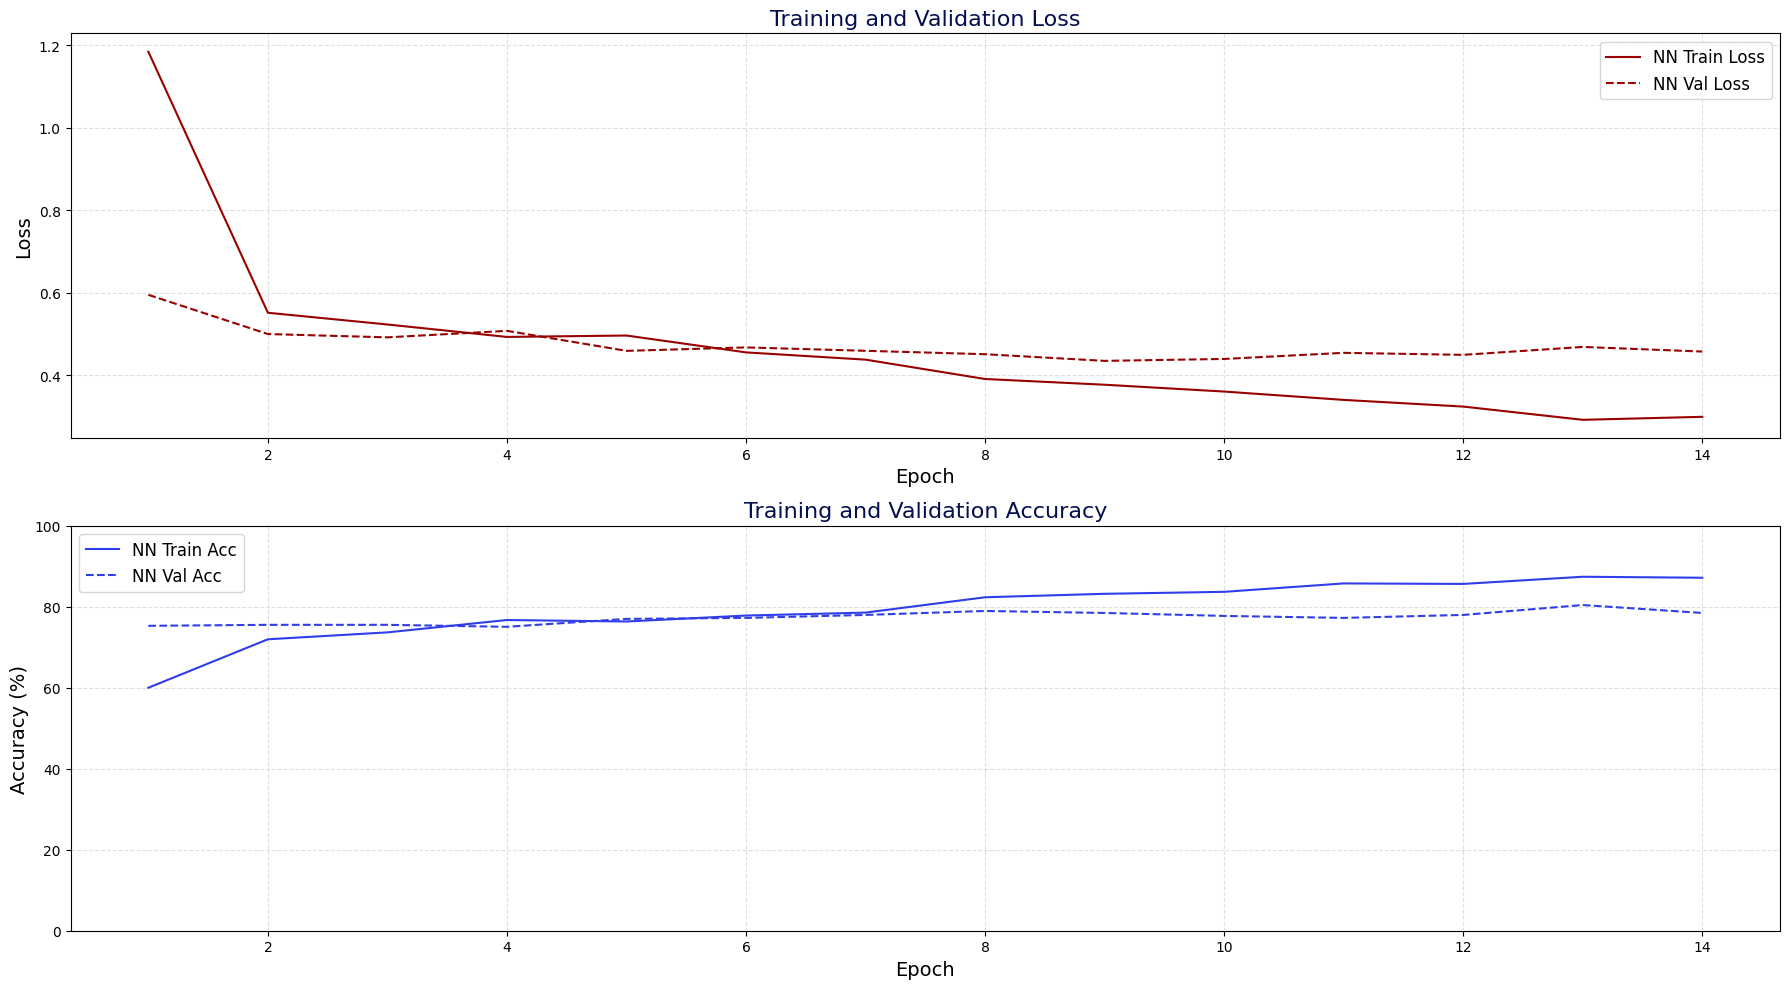

Evaluating the model on the test set
After conv1: torch.Size([64, 8, 224, 224])
After conv2: torch.Size([64, 32, 224, 224])
After conv3: torch.Size([64, 64, 112, 112])
After conv4: torch.Size([64, 64, 112, 112])
After convrest: torch.Size([64, 64, 56, 56])
After conv1: torch.Size([64, 8, 224, 224])
After conv2: torch.Size([64, 32, 224, 224])
After conv3: torch.Size([64, 64, 112, 112])
After conv4: torch.Size([64, 64, 112, 112])
After convrest: torch.Size([64, 64, 56, 56])
After conv1: torch.Size([64, 8, 224, 224])
After conv2: torch.Size([64, 32, 224, 224])
After conv3: torch.Size([64, 64, 112, 112])
After conv4: torch.Size([64, 64, 112, 112])
After convrest: torch.Size([64, 64, 56, 56])
After conv1: torch.Size([64, 8, 224, 224])
After conv2: torch.Size([64, 32, 224, 224])
After conv3: torch.Size([64, 64, 112, 112])
After conv4: torch.Size([64, 64, 112, 112])
After convrest: torch.Size([64, 64, 56, 56])
After conv1: torch.Size([64, 8, 224, 224])
After conv2: torch.Size([64, 32, 224, 22

0.7545649838882922

In [83]:

set_plot_style()

# check whether mps cuda or cpu
if torch.cuda.is_available():
    device = torch.device('cuda')
    print("CUDA VOLE")
else:
    device = torch.device('cpu')

data_dir = '/content/drive/MyDrive/DSV/hotdog_nothotdog'

size = 224
batch_size = 64


## Calculate mean and std
#mean_train, std_train = get_mean_std(train_loader_temp)
#print(f"Calculated mean: {mean_train}, std: {std_train}")

# calculate mean and std for test set
#mean_test, std_test = get_mean_std(test_loader_temp)
#print(f"Calculated mean: {mean_test}, std: {std_test}")


mean_train = torch.tensor([0.5226, 0.4412, 0.3585])
std_train = torch.tensor([0.2697, 0.2632, 0.2736])

mean_test = torch.tensor([0.5263, 0.4474, 0.3654])
std_test = torch.tensor([0.2688, 0.2633, 0.2754])

train_transform_norm = transforms.Compose([
    transforms.Resize((size, size)),
    transforms.ToTensor(),
    transforms.Normalize(mean=mean_train,
            std=std_train)])

test_transform_norm = transforms.Compose([
        transforms.Resize((size, size)),
        transforms.ToTensor(),
        transforms.Normalize(mean=mean_test,
                             std=std_test)
    ])

    #train_transform = transforms.Compose([
        #transforms.Resize((size, size)),
        #transforms.ToTensor(),
    #])
    #test_transform = transforms.Compose([
        #transforms.Resize((size, size)),
        #transforms.ToTensor(),
    #])

full_trainset = Hotdog_NotHotdog(train=True, transform=train_transform_norm, data_path=data_dir)
testset = Hotdog_NotHotdog(train=False, transform=test_transform_norm, data_path=data_dir)
validation_split = 0.2  # use 20% of the training data for validation
total_train = len(full_trainset)
val_size = int(total_train * validation_split)
train_size = total_train - val_size


    # Split the dataset
train_subset, val_subset = random_split(full_trainset, [train_size, val_size])


    # Create DataLoaders
train_loader = DataLoader(train_subset, batch_size=batch_size, shuffle=True, num_workers=4, pin_memory=True)
val_loader = DataLoader(val_subset, batch_size=batch_size, shuffle=False, num_workers=4, pin_memory=True)
test_loader = DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=4, pin_memory=True )

    #trainset = Hotdog_NotHotdog(train=True, transform=train_transform_norm, data_path=data_dir)
    #train_loader = DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=4, pin_memory=True)
    #testset = Hotdog_NotHotdog(train=False, transform=test_transform_norm, data_path=data_dir)
    #test_loader = DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=4, pin_memory=True)

print(f'The number of images in training set is: {len(train_subset)}')
print(f'The number of images in validation set is: {len(val_subset)}')
print(f'The number of images in test set is: {len(testset)}')

    # Visualize some training images
    #visualize_samples(train_loader)

    # Model setup
cnn_model = ChunkyBoyCut().to(device)

optimizer = torch.optim.Adam(cnn_model.parameters(), lr=0.0001, weight_decay=1e-5 )


print('Training the Chunky Model')
nn_out_dict, model = train(cnn_model, optimizer, device, train_loader, val_loader, num_epochs=20, patience=5)

#nn_out_dict = train(cnn_model, optimizer, device, train_loader, test_loader, num_epochs=2)
plot_training_curves(nn_out_dict)



        # Evaluate the model on the test set
print('Evaluating the model on the test set')
evaluate_on_test(cnn_model, device, test_loader)




In [87]:
# Get one batch of data
data_iter = iter(train_loader)
images, labels = next(data_iter)

# Select a random image
rnd = np.random.randint(0, len(images))
image = images[rnd].to(device).unsqueeze(0)  # Add a batch dimension

# Pass the image through the network to obtain intermediate channels
output = cnn_model.forward(image, cut=2)  # 'cut' defines the point in the network to stop
print(output.shape)

After conv1: torch.Size([1, 8, 224, 224])
After conv2: torch.Size([1, 32, 224, 224])
torch.Size([1, 32, 224, 224])


In [85]:

    data_iter = iter(train_loader)
    images, labels = next(data_iter)
    rnd = np.random.randint(0, len(images))
    image = images[50].to(device).unsqueeze(0)
    print(image.shape)
    output = cnn_model.forward(image, 5)
    print(output.shape)


torch.Size([1, 3, 224, 224])
After conv1: torch.Size([1, 8, 224, 224])
After conv2: torch.Size([1, 32, 224, 224])
After conv3: torch.Size([1, 64, 112, 112])
After conv4: torch.Size([1, 64, 112, 112])
After convrest: torch.Size([1, 64, 56, 56])
torch.Size([1, 1])


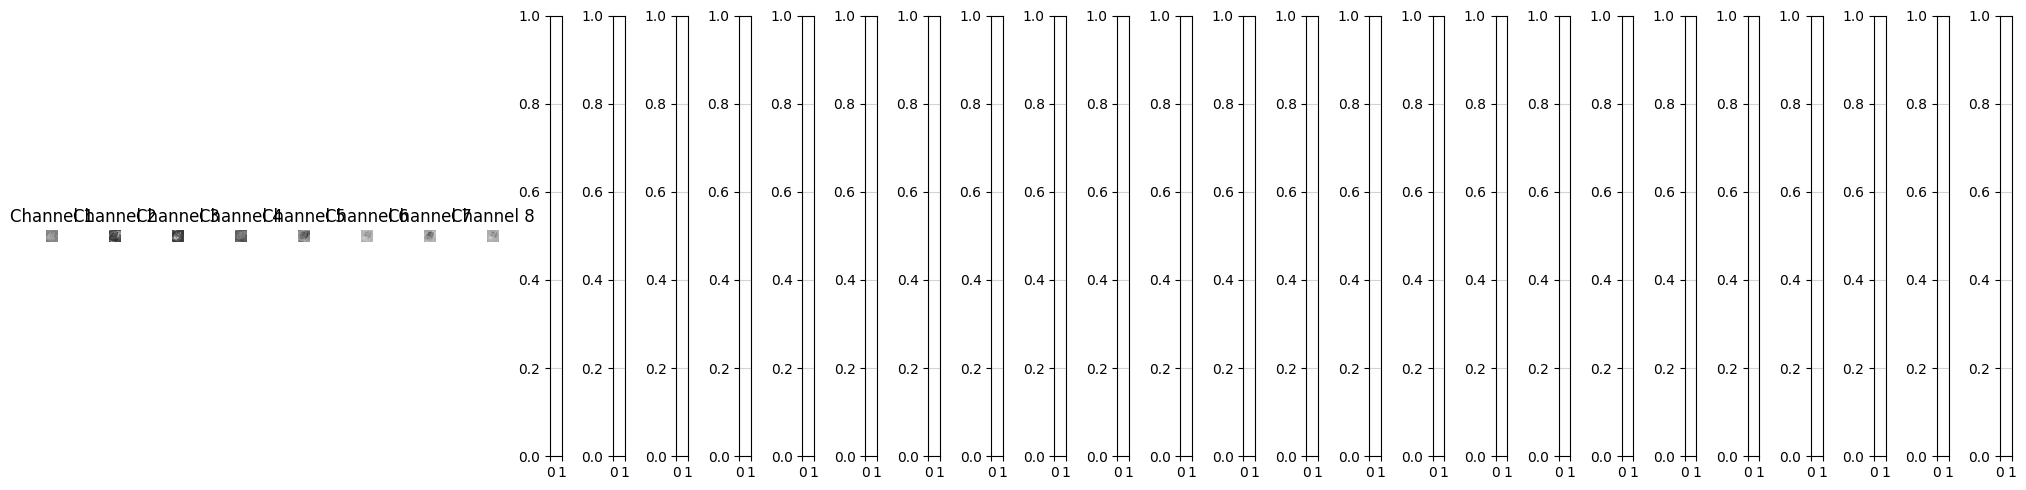

In [89]:
import matplotlib.pyplot as plt
import torch

# Assuming 'image' is your tensor with shape [1, 8, 224, 224]
# Move to CPU if necessary and convert to numpy
tensor = output.detach().cpu().numpy()

# Remove the batch dimension (1) using squeeze to get [8, 224, 224]
tensor_squeezed = tensor.squeeze(0)

# Plot each channel separately
fig, axs = plt.subplots(1,32, figsize=(20, 5))  # 8 subplots in a row

for i in range(8):
    axs[i].imshow(tensor_squeezed[i], cmap='gray')  # Removed .numpy() here
    axs[i].set_title(f'Channel {i+1}')
    axs[i].axis('off')  # Turn off the axis labels

plt.tight_layout()
plt.savefig(f'hotdog_channels{rnd}.png',dpi=300)
plt.show()
